<h1> Тестовое задание на ML-разработчика </h1>
<br>
Доброго времени суток, честно говоря, впервые делаю такого рода задания + делаю в попыхах, потому прошу строго не судить...

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('omw-1.4')

stop_words = set(stopwords.words('english') + ['ha', 'wa', 'say', 'said'])
lemmatizer = WordNetLemmatizer()

In [3]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [11]:
df_test = pd.read_csv('test_spam.csv')
df_test.sample(5)

,text
354,hmm if the shoe fits i think these five attrib...
2733,💯 𝐈 𝐬𝐭𝐚𝐫𝐭𝐞𝐝 𝐞𝐚𝐫𝐧𝐢𝐧𝐠 𝐭𝐡𝐞 𝐝𝐚𝐲 𝐈 𝐭𝐨𝐨𝐤 𝐭𝐡𝐞 𝐜𝐨𝐮𝐫𝐚𝐠𝐞...
3300,ebs stinson the spreadsheet below shows the al...
2567,❤️ just created an private channel ❤️ which ha...
166,daily rates jackups john claudio put together ...


In [5]:
df_train = pd.read_csv('train_spam.csv')
df_train.sample(5)

,text_type,text
3764,spam,dear friend i am mrs sese seko widow of late p...
9003,ham,minor updates
2518,ham,just use full path or set a custom variable $h...
9152,ham,informal exploratory interview with enron rese...
5121,spam,i was very happy when i received my profits fo...


In [6]:
df_train.shape

(16278, 2)

In [8]:
df_train['text_type'].value_counts()

ham     11469
spam     4809
Name: text_type, dtype: int64

**Авторское примечание** как я понимаю, перед работой с текстом нужно немного пошаманить 
* Приведем текст к нижнему регистру, разобьем его на токены.
* Оставим только буквенные слова (удалив, таким образом, пунктуацию и числа).
* Применим лемматизацию.
* Удалим стоп-слова.

In [13]:
df_train['text'] = df_train.apply(lambda row: preprocess(row.text), axis=1)
df_test['text'] = df_test.apply(lambda row: preprocess(row.text), axis=1)

**Авторское примечание** Тут я решил прикинуть, какие слова у нас преобладают в спамовых сообщениях

In [16]:
from wordcloud import WordCloud

def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)
    
    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

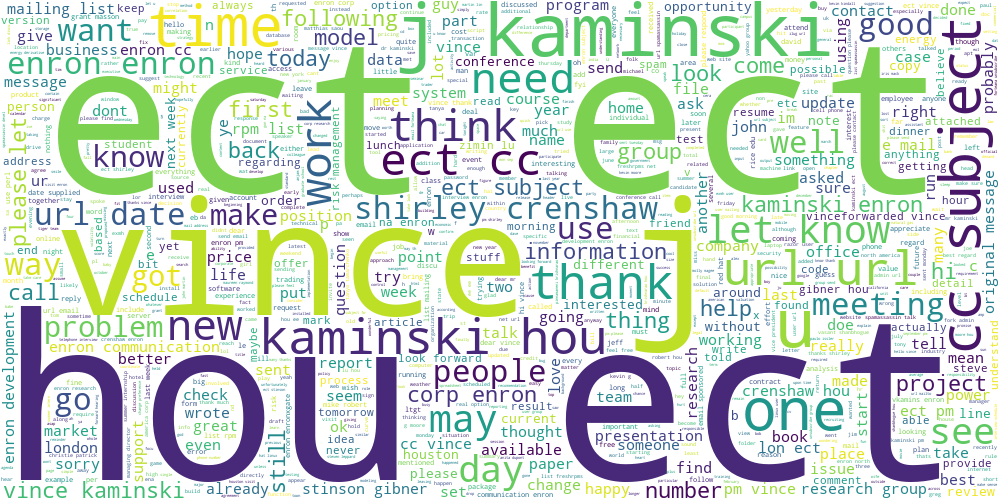

In [17]:
draw_wordcloud(df_train['text'].loc[df_train['text_type'] == 'ham'])

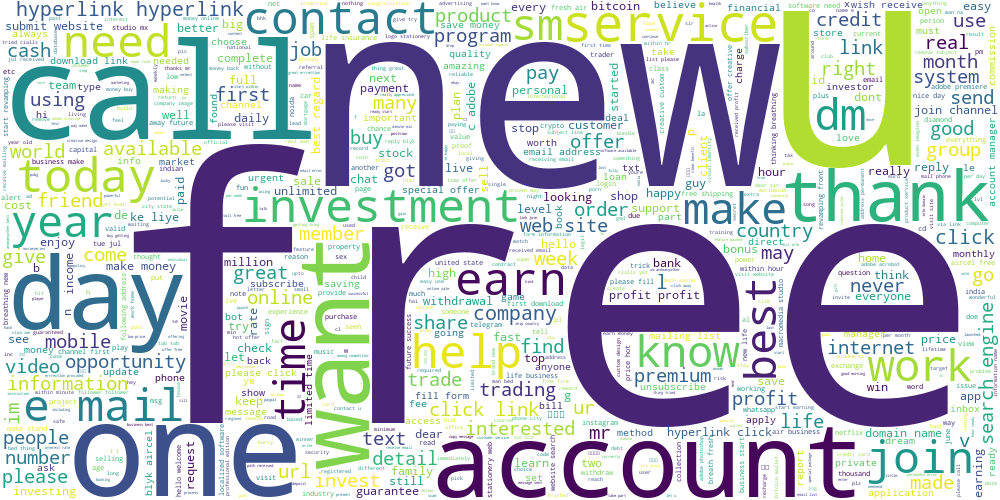

In [18]:
draw_wordcloud(df_train['text'].loc[df_train['text_type'] == 'spam'])

**Авторское примечание** Нус, какая-то логика тут определённо прослеживается, не так ли? Не буду подробно расписывать свою интуицию, но слова с первой группы ориентированны на личное общение, в то время как со второй скорее на материальную составляющую нашей жизни

Касаемо моделирования, навскидку приходят такие вариантики:
* Можно сделать разбивку на кластеры с помощью K-means'a DBSCAN'a (но его я сходу отметаю, у нас бинарная классификация, учитывая его особенности расстояние для нормального качества фиг подберёшь) или же Спектральной кластеризации и потом поверх этого дела накатить логистическую регрессию
* Можно запустить сырой catboost ну или же пошаманить с параметрами, хотя он и в стоке нормуль (+ отлично отрабатывает категориальные фичи)
* Можно запустить какой-нибудь другой бустинг, но не скалёновский
* Можно закинуть SVM поверх написанного в п.1 и посмотреть, что будет

Также не стоит забывать, что кластеры порой любят махнуться местами, но не думаю, что нам это сильно помешает, ведь класса всего 2

In [20]:
# Горы импорта

from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [39]:
tfidf_model = TfidfVectorizer()
tfidf_matrix = tfidf_model.fit_transform(df_train['text'])

In [40]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_matrix, df_train['text_type'], test_size=0.3, random_state=10)

In [41]:
cat_model = CatBoostClassifier()
cat_model.fit(x_train, y_train, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [42]:
y_pred = cat_model.predict(x_test)

In [47]:
roc_auc_score(y_test == 'ham', y_pred == 'ham')

0.8735426462594487

In [48]:
# Решил ещё на тестовой глянуть
y_pred_train = cat_model.predict(x_train)

In [49]:
roc_auc_score(y_train == 'ham', y_pred_train == 'ham')

0.9269725018067119

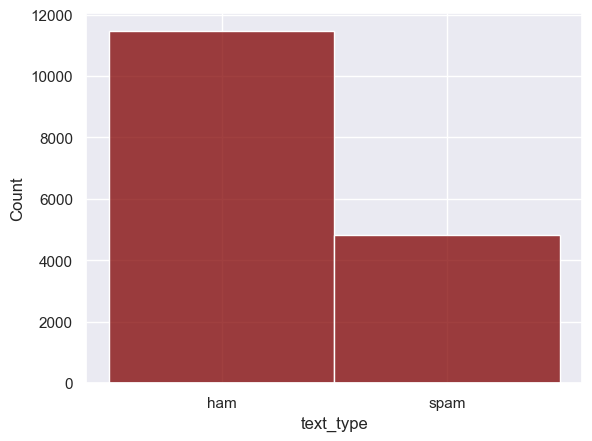

In [28]:
# тут осенило, почему бы не глянуть на дизбаланс классов... вроде бы он не такой и сильный, учитывая, сколько у нас наблюдений, переобучать не должно, покатит

sns.histplot(df_train['text_type'], color='maroon');

**Авторское примечание** Увы, мне не хватило времени на прогон остальных методов, начал с кэтбуста, ибо он лучше всех работает из коробки и тут в меньшей степени приходится париться с категориальными фичами, но вообще остальные описанные методы тоже норм, мб они выбьют и более 0.873, особенно возлагаю надежды на ядровой SWM и спектральную кластеризацию (но там мне пришлось бы очень долго париться с настройкой матрицы смежности), ибо тут могут находиться нелинейные взаимосвязи, но это лишь пустой трёп, т.к. времени всё равно не хватит, спасибо форсмажорам...

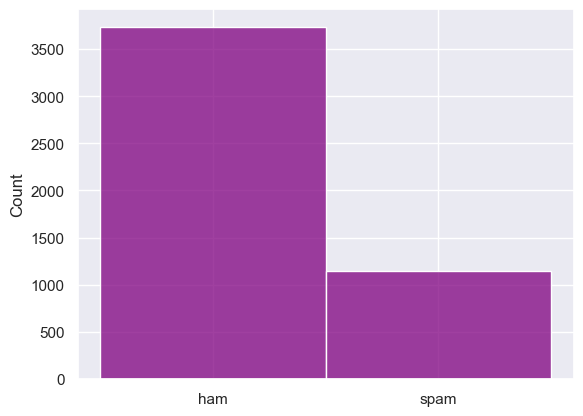

In [52]:
# На последок решил глянуть на баланс полученных классов у тестовой выборки

sns.histplot(y_pred, color='purple');

**Последнее авторское примечание** Вроде бы +- правильный баланс, с относительно нормальным качеством по нашей метрике, тут ещё дошло что на втором тестовом датасете присутствуют эмодзи и я не уверен, что зашитые в nltk фильтры от них избавляют, это может вызвать проблемы при токенизации, однако они скорее всего будут указывать на письма, что не относятся к спаму, т.к. обычно применяются в личных переписках, <br>
За сим откланяюсь, спасибо за прочтение